# Overview

> Gaussian Mixture Model (GMM) is often categorized as a clustering algorithm (similar to KMean) – i.e. the number of categories for the Z latent variable has been initialized as the number of clustered in question (which is equivalent to the number of Gaussian in the GMM model). For this project, GMM is used as a probability density estimation. It is a generative probabilistic model that is used to describe the distribution of the given sample data.

> ## Clustering

>> When GMM is used as clustering, then it needs to be initialized to the number of clusters. The EM algorithm will try to learn the “pattern” within the sample data, group similar data, and categorize them into the different clusters. The limitation of this is that each data point either belongs to a cluster completely or not. However, some datasets may not be well organized into clusters. so “naïve” clustering algorithm may not be able to cluster them correctly and accurately. For example, “Moon Shape”, there are 2 clusters/Gaussian. 

>> 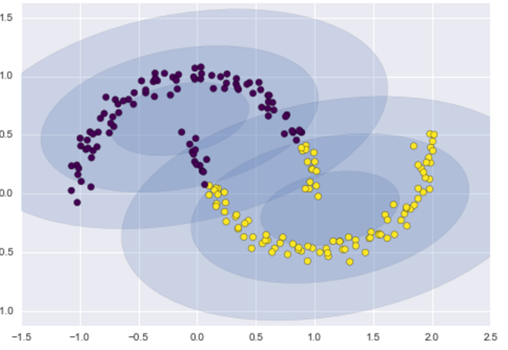

> ## Probability Density Estimation

>> The dataset is separated into k different subsets, one for each class. A GMM model is created for each subset. The model will estimate the probability distribution using the given training data. During prediction, each of the GMM models will provide a likelihood score. The maximum likelihood will be chosen. This is more flexible than clustering because each individual GMM model can contain many Gaussian (i.e. the latent variable Z is not limited to the number of classes anymore) to represent individual data subset.

>> 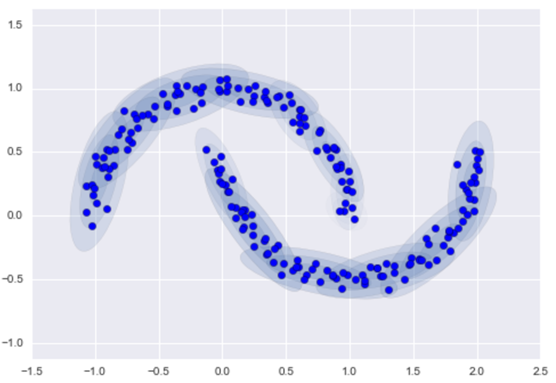

# Experiment

> For this experiment, two GMM classifiers will be created. One is created using the sklearn GaussianMixture model. The other torch-based GMM classifier first uses the sklearn GMM Classifier to learn the GMM model parameters using the training data (fit). The torch-based GMM classifier will then create the MixtureSameFamily (Categorical + MultivariateNormal) using these parameters. The reason of this is to allow later interation with the torch base attack framework that bases on PyTorchModel.

# References

> [In Depth: Gaussian Mixture Models](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)

# (1) Load the required packages

In [1]:
!pip install foolbox
# !pip install git+https://github.com/nottombrown/imagenet_stubs

     |████████████████████████████████| 1.7MB 17.8MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 163kB 55.9MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import time, torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np
from foolbox import PyTorchModel, accuracy, samples, plot, criteria, distances
import foolbox.attacks as fa
import torchvision.models as models
import eagerpy as ep
# from imagenet_stubs.imagenet_2012_labels import label_to_name
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.base import BaseEstimator, ClassifierMixin
from numpy.random import permutation

import torch.distributions as D

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# (2) Setup the GMM Classifier

*   GMMSKlearnClassifier - This classifier uses the GaussianMixture model provided by sklearn to build the GMM Classifier 
*   GMMTorchClassifier - The GMMSKlearnClassifier is embedded inside this torch-based classifier. GMMTorchClassifier first trains the GMMSKlearnClassifier using the training data. The trained parameters are passed to torch MixtureSameFamily (Categorical + MultivariateNormal) to build a torch-based GMM Classifier

In [4]:
class GMMSKlearnClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_components, n_features, covariance_type='spherical', max_iter=1000):
        self.n_component = n_components
        self.n_features = n_features
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        
    def initialize_gmm(self, k, y, weights, means, Sigmas):
        
        self.y_classes_ = np.unique(y)

        self.model_list_ = np.asarray([GaussianMixture(self.n_component, 
                                                       covariance_type=self.covariance_type, 
                                                       max_iter=self.max_iter, 
                                                       means_init=means[i],
                                                       weights_init=weights[i],
                                                       precisions_init=Sigmas[i],
                                                       random_state=0) 
                                     for i in range(k)])
        
    def fit(self, X, y):
        self.y_classes_ = np.unique(y)
        
        # Create a Subset list. Each X Subset for each Y Class
        X_train_subsets = np.asarray([X[y==self.y_classes_[i]] for i in range(self.y_classes_.shape[0])])
        
        # Create a GMM list. Each GMM for each X Subset for each Y Class
        # Train the GMM model with the X subset
        # The model will learn and estimate the density distribution (Gaussian - mu and Sigma)
        self.model_list_ = np.asarray([GaussianMixture(self.n_component, 
                                                     covariance_type=self.covariance_type, 
                                                     max_iter=self.max_iter, 
                                                     random_state=0).fit(X_train_subsets[i]) 
                                     for i in range(self.y_classes_.shape[0])])
        
        # Prior list which is the X Subset ratio based on the Sample data
        self.logprior_list_ = np.asarray([
            np.log(X_train_subsets[i].shape[0] / X.shape[0]) for i in range(self.y_classes_.shape[0])
        ])
        
        return self
    
    def predict(self, X, method='mle'):
        
        result = None
        if method == 'mle':
            # use np.argmax to find the max for each N
            # predict_proba return (k x N), so axis=0
            result = self.y_classes_[np.argmax(self.predict_proba_likelihood(X), axis=0)]
        elif method == 'post':
            result = self.y_classes_[np.argmax(self.predict_proba_posterior(X), axis=0)]
        else:
            print(f'Unsupported classification method')
    
        return result
    
    def predict_proba_likelihood(self, X):
        # (k x N)
        loglikelihood_list = np.asarray([self.model_list_[i].score_samples(X) for i in range(self.y_classes_.shape[0])])       
        likelihood_list = np.exp(loglikelihood_list)
        
        # Sum the likelihood_list over the k dimension, keep the number of N
        # (k x N) / (1 x N)
        normalized = likelihood_list / likelihood_list.sum(0, keepdims=True)
        
        # return (k x N) where the sum of the probabilities for each N is 1
        return normalized
    
    def predict_proba_posterior(self, X):
        # (k x N)
        loglikelihood_list = np.asarray([self.model_list_[i].score_samples(X) for i in range(self.y_classes_.shape[0])])
        # Need to change logprior_list from (k, ) to (k, 1)
        # (k x N) + (k, 1)
        posterior_list = np.exp(loglikelihood_list + self.logprior_list_[:, np.newaxis])
        
        # Sum the posterior_list over the k dimension, keep the number of N
        # (k x N) / (1 x N)
        normalized = posterior_list / posterior_list.sum(0, keepdims=True)
        
        # return (k x N) where the sum of the probabilities for each N is 1
        return normalized
    
    def get_gmm_params(self):
        means_list = []
        weights_list = []
        covariances_list = []
        for i in range(self.y_classes_.shape[0]):
            means_list.append(self.model_list_[i].means_)
            weights_list.append(self.model_list_[i].weights_)
            covariances_list.append(self.model_list_[i].covariances_)
            
        return np.asarray(means_list), np.asarray(weights_list), np.asarray(covariances_list)


class GMMTorchClassifier(torch.nn.Module):
    
    def __init__(self, n_components, n_features, covariance_type='spherical', max_iter=1000):
        super().__init__()
        self.n_components = n_components
        self.n_features = n_features
        self.covariance_type = covariance_type
        self.max_iter = max_iter

    def fit(self, X, y):
        
        # 1. Use sklearn to train and get the means, weights, and variances parameters
        #
        X_np = X.detach().cpu().numpy()
        y_np = y.detach().cpu().numpy()
        
        sklearn_gmm_clf = GMMSKlearnClassifier(
            n_components=self.n_components,
            n_features=self.n_features,
            covariance_type=self.covariance_type,
            max_iter=self.max_iter,
        ).fit(X_np, y_np)
        
        means_list_np, weights_list_np, variances_list_np = sklearn_gmm_clf.get_gmm_params()
        
        self.y_classes_ = torch.unique(y).to(device=device)

        # Create a Subset list. Each X Subset for each Y Class
        X_train_subsets = [X[y==self.y_classes_[i]] for i in range(self.y_classes_.shape[0])]
        
        self.model_list_ = []
        for i in range(self.y_classes_.shape[0]):
            weights = torch.from_numpy(weights_list_np[i]).float().to(device=device)  # n_components
            means = torch.from_numpy(means_list_np[i]).float().to(device=device)      # n_components x n_features
            variances = torch.from_numpy(variances_list_np[i]).float().to(device=device) # n_components
            
            
            # covar = k x D x D 
            covariances_list = torch.empty((variances.shape[0], self.n_features, self.n_features)).to(device=device)
            for i in range(variances.shape[0]):
                covariances_list[i] = torch.eye(self.n_features).to(device=device) * variances[i]
    
            mix = D.Categorical(weights)
            comp = D.MultivariateNormal(means, scale_tril=torch.cholesky(covariances_list))
            gmm = D.MixtureSameFamily(mix, comp)
            self.model_list_.append(gmm)

    def forward(self, X):

        X = X.reshape(X.shape[0], -1)

        likelihood_list = self.predict_proba_likelihood(X)
        softmax = torch.nn.Softmax(dim=0)
        softmax_list = softmax(likelihood_list)

        return softmax_list.T

    def predict(self, X):
        
        likelihood_list = self.predict_proba_likelihood(X)
        softmax = torch.nn.Softmax(dim=0)
        softmax_list = softmax(likelihood_list)
        
        result = self.y_classes_[torch.argmax(softmax_list, axis=0)]
        return result

    def predict_proba_likelihood(self, X):
        # (k x N)
        loglikelihood_list = torch.empty((self.y_classes_.shape[0], X.shape[0])).to(device=device)
        for i in range(self.y_classes_.shape[0]):
            loglikelihood_list[i] = self.model_list_[i].log_prob(X)

        return loglikelihood_list
        
        

# (3) Train the GMM model before the attack

## (3a) Prepare the MNIST dataset for training

In [5]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(X_train.shape))
print('Training Labels: {}'.format(y_train.shape))
print('Testing Data: {}'.format(X_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

11493376/11490434 [==============================] - 0s 0us/step
Training Data: (60000, 28, 28)
Training Labels: (60000,)
Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


## (3b) Data Preprocessing

*   Flatten each image from 2-D (28, 28) into 1-D (784)
*   Normalize the data to 0 - 1
*   Also find the number of class label (i.e. for MNIST, it is digits 0 to 9)



In [6]:
# preprocessing the images

# convert each image to 1 dimensional array
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

# normalize the data to 0 - 1
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.

y_classes = set(y_train)

print(X_train.shape)
print(X_train[0].shape)
print(X_test.shape)
print(X_test[0].shape)
print(y_train.shape)
print(y_test.shape)
print(f'Y Class Labels: {y_classes}')

(60000, 784)
(784,)
(10000, 784)
(784,)
(60000,)
(10000,)
Y Class Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [7]:

perm_train = permutation(X_train.shape[0])
perm_test = permutation(X_test.shape[0])

# X_train_torch = torch.from_numpy(X_train[perm_train][:5000]).float().to(device=device)
# y_train_torch = torch.from_numpy(y_train[perm_train][:5000]).float().to(device=device)
X_train_torch = torch.from_numpy(X_train[perm_train][:]).float().to(device=device)
y_train_torch = torch.from_numpy(y_train[perm_train][:]).float().to(device=device)
X_test_torch = torch.from_numpy(X_test[perm_test][:100]).float().to(device=device)
y_test_torch = torch.from_numpy(y_test[perm_test][:100]).float().to(device=device)

print(X_train_torch.shape)
print(y_train_torch.shape)
print(X_train_torch.device)
print(y_train_torch.device)

torch.Size([60000, 784])
torch.Size([60000])
cuda:0
cuda:0


## (3c) Train the GMM Classifier

In [8]:
gmm_clf_torch = GMMTorchClassifier(n_components=20, n_features=X_train_torch.shape[1], covariance_type='spherical').to(device=device)
gmm_clf_torch.fit(X_train_torch, y_train_torch)



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## (3d) Test the GMM Classifier

In [9]:
y_pred = gmm_clf_torch.predict(X_test_torch)
acc = torch.sum(y_pred==y_test_torch)/y_test_torch.shape[0]
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 93.00%


# (4) Perform the attack on the trained model

## (4a) Helper functions

In [10]:
def plot_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(24, 24))

    for i, ax in enumerate(axs.flat):
        image = images[i]
        image = np.squeeze(image, axis=0)
        ax.matshow(image)
        ax.axis('off')
        ax.set_title(f'Image {i}')

    fig.show()

## (4b) Setup the PyTorchModel and do a simple test 

labels     :  [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]
predictions:  [7, 2, 1, 0, 4, 1, 4, 9, 9, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]
clean accuracy:  95.0 %



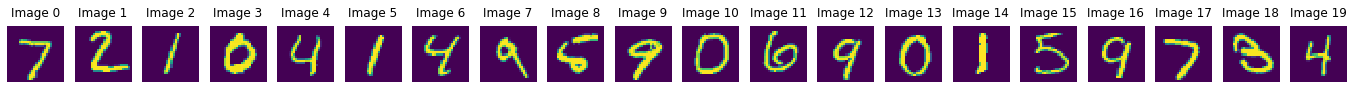

In [11]:
model = gmm_clf_torch.eval()
fmodel = PyTorchModel(model, bounds=(0, 1))
batch_size = 20
images, labels = samples(fmodel, dataset="mnist", batchsize=20)

clean_acc = accuracy(fmodel, images, labels)
predictions = fmodel(images).argmax(-1)
plot_images(images.cpu().numpy())
print("labels     : ", [l for l in labels.cpu().numpy()])
print("predictions: ", [l for l in predictions.cpu().numpy()])

print(f"clean accuracy:  {clean_acc * 100:.1f} %")
print("")

## (4c) Start the actual attack

epsilons
[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1.0]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.9  0.9  0.9 ]
Time taken:  0.056793594360351564 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.9  0.75 0.65 0.65]
Time taken:  0.050647079944610596 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.9  0.9  0.9 ]
Time taken:  1.6960113406181336 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=T

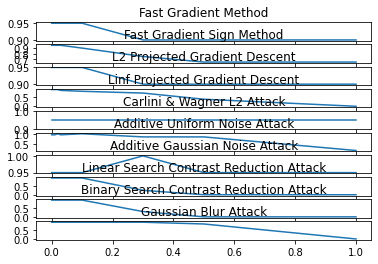

In [12]:
%matplotlib inline

attacks = [
           # gradient-based attacks
           {"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack()},
           {"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack()},
           {"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack()},
           {"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack()},
           {"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack()},
           # decision-based attacks
        #    {"name": "Boundary Attack", "model": fa.BoundaryAttack()},
           {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack()},
           {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack()},
           {"name": "Linear Search Contrast Reduction Attack", "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Binary Search Contrast Reduction Attack", "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf)},
]
    
epsilons = [
        0.0,
        0.0005,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.005,
        0.01,
        0.02,
        0.03,
        0.1,
        0.3,
        0.5,
        1.0,
    ]
print("epsilons")
print(epsilons)
print("")

attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
fig, axs = plt.subplots(len(attacks))
fig.tight_layout()
for i, attack in enumerate(attacks):
    # plot_images(images.cpu().numpy())
    # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
    # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
    # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
    t1 = time.time()
    raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=epsilons)
    t2 = time.time()
    success_ = is_adv.cpu().numpy()
    attack_success[i] = success_
    print(attack)
    print("  ", 1.0 - success_.mean(axis=-1).round(2))
    print("Time taken: ", (t2 - t1) / batch_size, "seconds")

    # plot the robust accuracy against epsilons for the particular attack
    robust_accuracy = 1 - is_adv.float().mean(axis=-1)
    axs[i].plot(epsilons, robust_accuracy.cpu().numpy())
    axs[i].set_title(attack["name"])
    # axs.plot(epsilons, robust_accuracy.cpu().numpy())
    # axs.set_title(attack["name"])

    print("Clipped adversaries: ")
    # plot_images(clipped_adv[0].cpu().numpy())


## (4d) Print the best attack per sample

In [13]:
# calculate and report the robust accuracy (the accuracy of the model when
# it is attacked) using the best attack per sample
robust_accuracy = 1.0 - attack_success.max(axis=0).mean(axis=-1)
print("")
print("-" * 79)
print("")
print("worst case (best attack per-sample)")
print("  ", robust_accuracy.round(2))
print("")

print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")


-------------------------------------------------------------------------------

worst case (best attack per-sample)
   [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.9  0.85 0.2  0.   0.  ]

robust accuracy for perturbations with
  Linf norm ≤ 0.0   : 95.0 %
  Linf norm ≤ 0.0005: 95.0 %
  Linf norm ≤ 0.001 : 95.0 %
  Linf norm ≤ 0.0015: 95.0 %
  Linf norm ≤ 0.002 : 95.0 %
  Linf norm ≤ 0.003 : 95.0 %
  Linf norm ≤ 0.005 : 95.0 %
  Linf norm ≤ 0.01  : 95.0 %
  Linf norm ≤ 0.02  : 95.0 %
  Linf norm ≤ 0.03  : 90.0 %
  Linf norm ≤ 0.1   : 85.0 %
  Linf norm ≤ 0.3   : 20.0 %
  Linf norm ≤ 0.5   :  0.0 %
  Linf norm ≤ 1.0   :  0.0 %


## (4e) Start multiple attacks


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!
epsilons
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Run 1 clean accuracy:  93.8 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
Time taken:  0.04445185661315918 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.94 0.94 0.81 0.78 0.78 0.78 0.78 0.78 0.78 0.78 0.78]
Time taken:  0.039916503429412845 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
Time taken:  1.3424396872520448 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.94 0.91 0.75 0.75 0.62 0.5  0.34 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.97 0.94 0.91 0.91 0.91 0.91 0.91 0.91 0.88 0.88 0.88]
Time taken:  0.040267348289489746 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.97 0.91 0.84 0.78 0.75 0.72 0.72 0.72 0.72 0.72 0.72]
Time taken:  0.03998699188232422 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.97 0.94 0.91 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88]
Time taken:  1.3308493852615357 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.97 0.84 0.84 0.72 0.59 0.34 0.22 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91]
Time taken:  0.04013471603393555 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.91 0.91 0.84 0.81 0.84 0.84 0.88 0.88 0.88 0.88 0.88]
Time taken:  0.039466357231140135 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.91 0.91 0.91 0.91 0.88 0.88 0.88 0.88 0.88 0.88 0.88]
Time taken:  1.327768123149872 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.91 0.84 0.81 0.81 0.66 0.44 0.19 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.97 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
Time taken:  0.0402222990989685 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.97 0.94 0.84 0.81 0.81 0.84 0.84 0.84 0.84 0.88 0.88]
Time taken:  0.03958570957183838 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.97 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
Time taken:  1.334571659564972 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.97 0.94 0.81 0.75 0.47 0.28 0.16 0.12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.94 0.91 0.91 0.91 0.91 0.88 0.88 0.88 0.88 0.88 0.88]
Time taken:  0.040205645561218264 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.94 0.88 0.84 0.88 0.88 0.84 0.84 0.84 0.84 0.84 0.84]
Time taken:  0.03983393907546997 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.94 0.91 0.91 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88]
Time taken:  1.341891086101532 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.94 0.84 0.81 0.72 0.53 0.41 0.28 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [1.   0.97 0.97 0.97 0.97 0.94 0.94 0.94 0.94 0.94 0.94]
Time taken:  0.04016321897506714 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [1.   0.91 0.88 0.81 0.91 0.88 0.84 0.84 0.84 0.84 0.84]
Time taken:  0.03956916332244873 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [1.   0.97 0.97 0.94 0.91 0.88 0.88 0.88 0.88 0.88 0.88]
Time taken:  1.3336318254470825 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [1.   0.88 0.81 0.66 0.56 0.34 0.12 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.97 0.97 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.91 0.91]
Time taken:  0.03964155912399292 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.97 0.91 0.84 0.81 0.84 0.84 0.84 0.84 0.84 0.84 0.84]
Time taken:  0.03922579288482666 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.97 0.97 0.94 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91]
Time taken:  1.3264634728431701 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.97 0.88 0.84 0.69 0.53 0.31 0.22 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.94 0.91 0.91 0.91 0.91 0.91 0.91 0.88 0.88 0.88 0.88]
Time taken:  0.04016437530517578 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.94 0.88 0.75 0.69 0.72 0.75 0.75 0.75 0.75 0.75 0.75]
Time taken:  0.03959883451461792 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.94 0.91 0.91 0.91 0.91 0.88 0.88 0.88 0.88 0.88 0.84]
Time taken:  1.33647563457489 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.94 0.78 0.66 0.62 0.5  0.41 0.19 0.06

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [1.   1.   1.   1.   1.   0.97 0.97 0.97 0.97 0.97 0.97]
Time taken:  0.040541231632232666 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [1.   1.   0.97 0.97 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
Time taken:  0.0396808385848999 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [1.   1.   1.   1.   0.97 0.97 0.97 0.97 0.97 0.97 0.97]
Time taken:  1.3335717082023621 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [1.   0.94 0.88 0.78 0.62 0.41 0.28 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


{'name': 'Fast Gradient Method', 'model': L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.91 0.91 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88]
Time taken:  0.040027189254760745 seconds
Clipped adversaries: 
{'name': 'Fast Gradient Sign Method', 'model': LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)}
   [0.91 0.88 0.84 0.78 0.78 0.81 0.78 0.78 0.81 0.81 0.81]
Time taken:  0.03926373720169067 seconds
Clipped adversaries: 
{'name': 'L2 Projected Gradient Descent', 'model': L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, steps=50, random_start=True)}
   [0.91 0.91 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.88]
Time taken:  1.3271783471107483 seconds
Clipped adversaries: 
{'name': 'Linf Projected Gradient Descent', 'model': LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)}
   [0.91 0.84 0.75 0.56 0.44 0.31 0.16 0

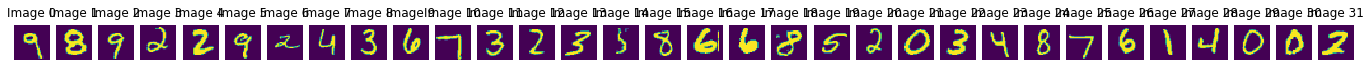

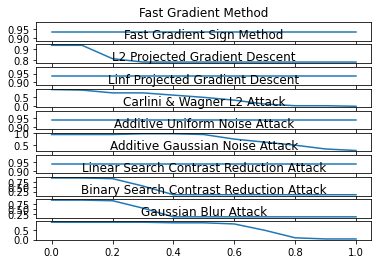

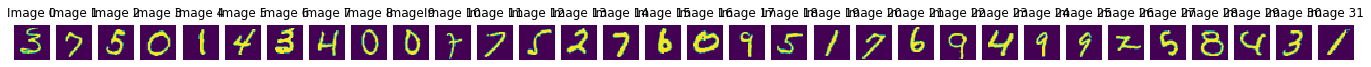

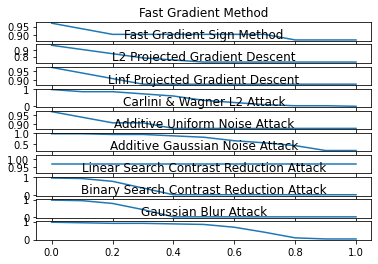

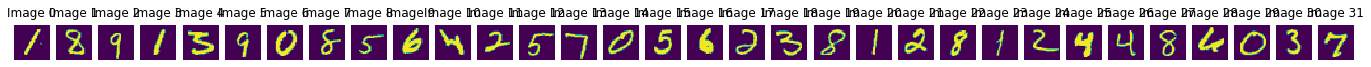

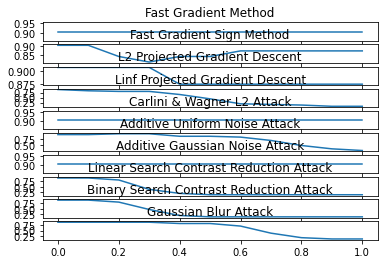

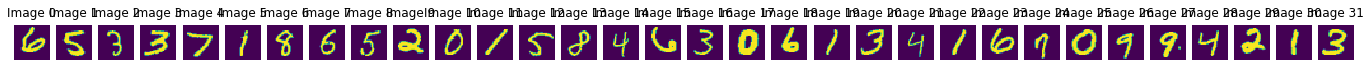

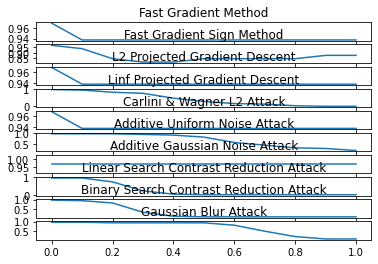

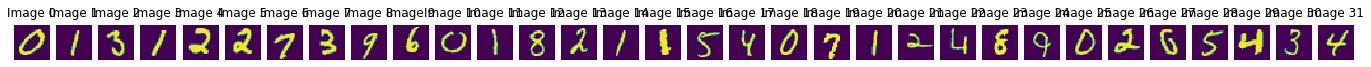

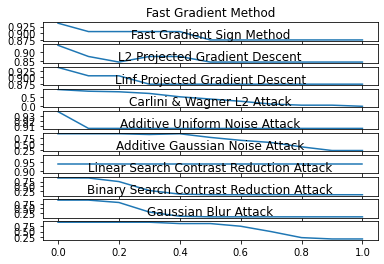

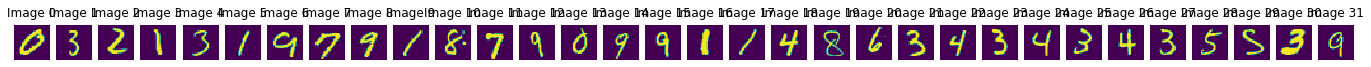

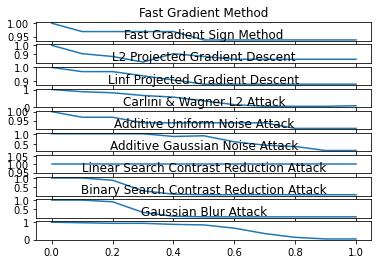

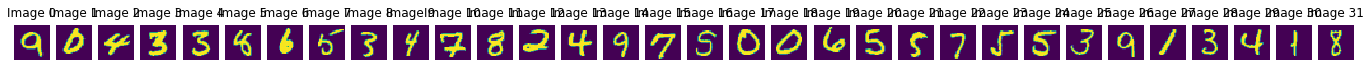

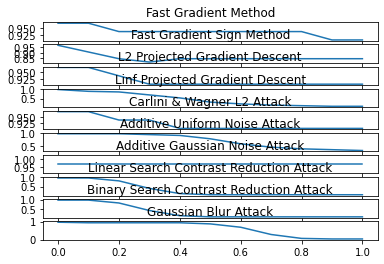

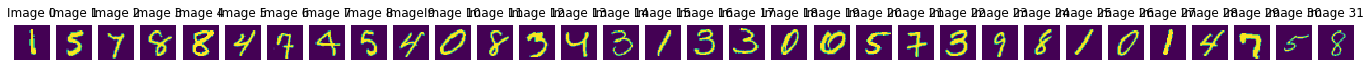

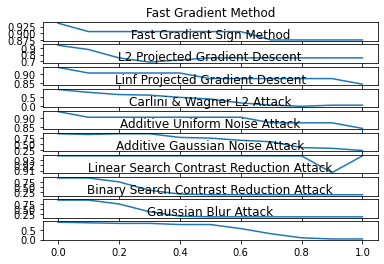

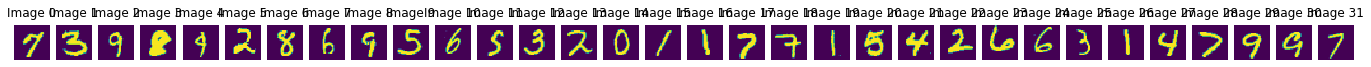

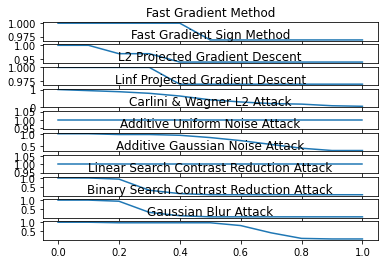

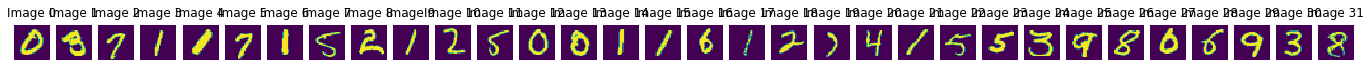

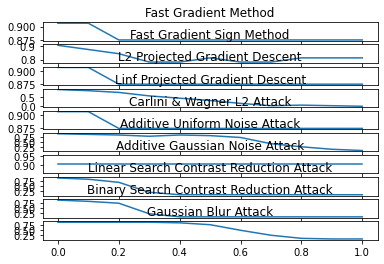

In [14]:
test = MNIST(root='.', train=False, transform=transforms.ToTensor(),download=True)
testloader  = DataLoader(dataset=test, batch_size=32, shuffle=True)

%matplotlib inline

attacks = [
           # gradient-based attacks
           {"name": "Fast Gradient Method", "model": fa.L2FastGradientAttack()},
           {"name": "Fast Gradient Sign Method", "model": fa.LinfFastGradientAttack()},
           {"name": "L2 Projected Gradient Descent", "model": fa.L2ProjectedGradientDescentAttack()},
           {"name": "Linf Projected Gradient Descent", "model": fa.LinfProjectedGradientDescentAttack()},
           {"name": "Carlini & Wagner L2 Attack", "model": fa.L2CarliniWagnerAttack()},
           # decision-based attacks
        #    {"name": "Boundary Attack", "model": fa.BoundaryAttack()},
           {"name": "Additive Uniform Noise Attack", "model": fa.LinfAdditiveUniformNoiseAttack()},
           {"name": "Additive Gaussian Noise Attack", "model": fa.L2AdditiveGaussianNoiseAttack()},
           {"name": "Linear Search Contrast Reduction Attack", "model": fa.LinearSearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Binary Search Contrast Reduction Attack", "model": fa.BinarySearchContrastReductionAttack(distance=distances.linf)},
           {"name": "Gaussian Blur Attack", "model": fa.GaussianBlurAttack(distance=distances.linf)},
]
    
epsilons = [
        0.0,
        0.1,
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
        1.0,
    ]
print("epsilons")
print(epsilons)
print("")

attack_results = {}
for attack in attacks:
    attack_results[attack['name']] = []

num_of_run = 10
curr_run = 0
for (images, labels) in testloader:

    images = images.to(device)
    labels = labels.to(device)

    plot_images(images.cpu().numpy())

    images = ep.astensor(images)
    labels = ep.astensor(labels)

    clean_acc = accuracy(fmodel, images, labels)
    print(f"Run {curr_run+1} clean accuracy:  {clean_acc * 100:.1f} %")    

    attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
    fig, axs = plt.subplots(len(attacks))
    fig.tight_layout()
    for i, attack in enumerate(attacks):
        # plot_images(images.cpu().numpy())
        # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
        # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
        # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
        t1 = time.time()
        raw_adv, clipped_adv, is_adv = attack["model"](fmodel, images, labels, epsilons=epsilons)
        t2 = time.time()
        success_ = is_adv.numpy()
        attack_success[i] = success_
        print(attack)
        print("  ", 1.0 - success_.mean(axis=-1).round(2))
        print("Time taken: ", (t2 - t1) / batch_size, "seconds")

        # plot the robust accuracy against epsilons for the particular attack
        robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
        axs[i].plot(epsilons, robust_accuracy.numpy())
        axs[i].set_title(attack["name"])
        # axs.plot(epsilons, robust_accuracy.cpu().numpy())
        # axs.set_title(attack["name"])

        print("Clipped adversaries: ")
        # plot_images(clipped_adv[0].cpu().numpy())

        attack_results[attack["name"]].append(robust_accuracy.numpy())

    curr_run += 1
    if curr_run >= num_of_run:
        break


## (4f) Print the average scores per attack for the multiple runs

In [15]:
for attack_name, value in attack_results.items():
    result_list = np.asarray(value)
    avg_results = np.mean(result_list, axis=0)
    print(f'Attack: {attack_name}')
    print(f'Epsilon: {epsilons}')
    print(f'Result: {np.around(avg_results, 3)}')
    print()

Attack: Fast Gradient Method
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.953 0.938 0.928 0.928 0.928 0.919 0.919 0.916 0.912 0.909 0.909]

Attack: Fast Gradient Sign Method
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.953 0.912 0.847 0.812 0.825 0.825 0.822 0.822 0.825 0.828 0.828]

Attack: L2 Projected Gradient Descent
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.953 0.938 0.928 0.916 0.906 0.9   0.9   0.9   0.9   0.9   0.897]

Attack: Linf Projected Gradient Descent
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.953 0.869 0.797 0.706 0.553 0.375 0.216 0.109 0.066 0.047 0.031]

Attack: Carlini & Wagner L2 Attack
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.953 0.938 0.928 0.925 0.919 0.919 0.919 0.916 0.912 0.912 0.909]

Attack: Additive Uniform Noise Attack
Epsilon: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Result: [0.

In [16]:
# a = []
# while(1):
#     a.append("111111111111111111111111111111")